In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# %reload_ext autoreload

In [22]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils
import mops, harris

# Detect Corners

In [23]:
im1 = utils.read_img("data/plush1.jpg")
im2 = utils.read_img("data/plush2.jpg")
im1_gray = utils.read_img("data/plush1.jpg", gray=True)
im2_gray = utils.read_img("data/plush2.jpg", gray=True)

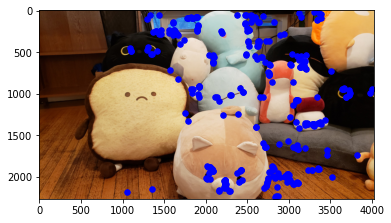

ValueError: too many values to unpack (expected 3)

In [24]:
strength1, corners1 = harris.get_corners(im1_gray)
utils.plot_pts(im1, corners1)
c1 = mops.detect_corners(im1)
utils.plot_pts(im1, corners2)
utils.plot_pts(im1, c1)

In [ ]:
strength2, corners2 = harris.get_corners(im2_gray)
utils.plot_pts(im2, corners2)
c2 = mops.detect_corners(im2)
utils.plot_pts(im2, corners2)
utils.plot_pts(im2, c2)

# Do Adaptive Non-Maximal Suppression

In [ ]:
strength1

In [ ]:
detected_corners = corners1
for corner in detected_corners:
    pass

In [29]:
from skimage.feature import corner_harris, corner_peaks
square = np.zeros([10, 10])
square[2:8, 2:9] = 1

In [30]:
square.astype(int)
# corner_peaks(corner_harris(square), min_distance=1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [37]:
# square.astype(int)
corners = corner_peaks(corner_harris(square), min_distance=1)
corners

array([[2, 2],
       [2, 8],
       [7, 2],
       [7, 8]])

In [33]:
corner_harris(square).shape

(10, 10)

In [42]:
corners

array([[2, 2],
       [2, 8],
       [7, 2],
       [7, 8]])

In [43]:
im = np.zeros_like(square)
im[corners[:, 0], corners[:, 1]] = 1

In [44]:
im

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

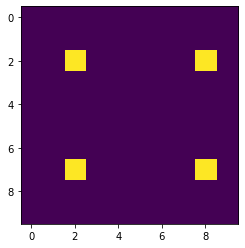

In [45]:
plt.imshow(im)

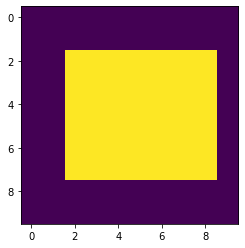

In [35]:
plt.imshow(square)